<a href="https://colab.research.google.com/github/piyushpatro/Stocks-Analysis/blob/main/VIX_PairTrade_Classify_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_path='/content/drive/MyDrive/Copy of data.csv'
df=pd.read_csv(path, parse_dates=True)
df['date']=pd.to_datetime(df['date'])

## Ranking the stocks using Volatility index of that stock by week

In [ ]:
# Function to get the weekly vix of a given stock

def get_weekly_vix(df, stock_name):
    temp_df=df.loc[df['Name']==stock_name]
    temp_df['year']=temp_df['date'].dt.year
    temp_df['week']=temp_df['date'].dt.week
    temp_df.drop('date', inplace=True, axis=1)
    logic={'open':'first', 'high':'max', 'low':'min', 
           'close':'last','volume':'sum'}
    grouped_data=temp_df.groupby(['year', 'week']).agg(logic)
    grouped_data.reset_index(inplace=True)
    grouped_data.drop(index=0, inplace=True)
    year_week=[]
    std=[]
    for i in range(1, len(grouped_data)-1):
        year_week.append(str(grouped_data['year'][i])+'-'+str(grouped_data['week'][i]))
        std.append(np.std([grouped_data['high'][i], grouped_data['high'][i+1]]))
    return stock_name, year_week, np.round(std,2)


vix_list=[]
year_week_list=[]
name_list=[]
for stock_name in np.unique(df['Name']):
    vix_list.append(get_weekly_vix(df, stock_name)[2])   
    year_week_list.append(get_weekly_vix(df, stock_name)[1])
    name_list.append(stock_name)

vix_df=pd.DataFrame(data=vix_list, index=name_list)
vix_df=vix_df.transpose()

sub_1=[]
for i in range(len(vix_df)):
    sub_1.append(vix_df.iloc[i][:].sort_values(ascending=False).index)

sub_1_df=pd.DataFrame(sub_1)
sub_1_df=sub_1_df.transpose()
sub_1_df.columns=year_week_list[0]

In [ ]:
sub_1_df

,2013-6,2013-7,2013-8,2013-9,2013-10,2013-11,2013-12,2013-13,2013-14,2013-15,2013-16,2013-17,2013-18,2013-19,2013-20,2013-21,2013-22,2013-23,2013-24,2013-25,2013-26,2013-27,2013-28,2013-29,2013-30,2013-31,2013-32,2013-33,2013-34,2013-35,2013-36,2013-37,2013-38,2013-39,2013-40,2013-41,2013-42,2013-43,2013-44,2013-45,...,2017-17,2017-18,2017-19,2017-20,2017-21,2017-22,2017-23,2017-24,2017-25,2017-26,2017-27,2017-28,2017-29,2017-30,2017-31,2017-32,2017-33,2017-34,2017-35,2017-36,2017-37,2017-38,2017-39,2017-40,2017-41,2017-42,2017-43,2017-44,2017-45,2017-46,2017-47,2017-48,2017-49,2017-50,2017-51,2017-52,2018-1,2018-2,2018-3,2018-4
0,GOOG,GOOG,GOOG,GOOG,ISRG,PCLN,BIIB,GOOG,PCLN,VRTX,IBM,REGN,PCLN,PCLN,PCLN,PCLN,EQIX,PVH,GOOG,WHR,PCLN,PCLN,ISRG,SHW,PXD,PCLN,REGN,PCLN,GOOG,REGN,PCLN,PCLN,PCLN,PCLN,EQIX,GOOGL,PCLN,PCLN,BIIB,PCLN,...,PCLN,NVDA,PCLN,PCLN,AZO,NVDA,PCLN,REGN,CMG,GOOGL,AZO,PCLN,AMZN,AMZN,PXD,PCLN,PCLN,PCLN,TDG,REGN,CHTR,AMZN,PCLN,PCLN,GWW,AMZN,CMG,MTD,PCLN,AMZN,AZO,AZO,AZO,PCLN,PCLN,PCLN,PCLN,AMZN,AMZN,AMZN
1,REGN,REGN,EQIX,GOOGL,XEC,AMZN,ALLE,HUM,REGN,CMG,PCLN,AMZN,GOOG,GOOGL,AZO,REGN,BLK,BIIB,PCLN,BLK,CMG,REGN,TDG,TRIP,EXPE,ESS,PCLN,EQIX,AMGN,BIIB,REGN,REGN,ADS,IQV,PCLN,CMG,AMZN,AME,CMG,PXD,...,MTD,CHTR,AZO,GOOGL,PCLN,AYI,GOOGL,AZO,AYI,AMZN,PCLN,VRTX,CMG,GOOGL,PCLN,ISRG,AMZN,BIIB,ISRG,PCLN,EQIX,GOOGL,AMZN,GOOGL,ADBE,GOOGL,PCLN,PCLN,REGN,PCLN,AMZN,AMZN,PCLN,PXD,GOOGL,AZO,AMZN,BLK,GWW,DPS
2,GWW,ULTA,KSU,PCLN,CMG,CHTR,FDX,REGN,CMG,GWW,AZO,GOOGL,GOOGL,BLK,REGN,GOOGL,SPG,ULTA,REGN,GOOGL,GOOG,ALXN,CMG,APD,MHK,AMZN,BIIB,ESS,QRVO,QRVO,ULTA,AMZN,BLK,PXD,IQV,PXD,CMG,GOOG,AME,AZO,...,REGN,EA,AYI,AMZN,COO,GOOGL,AMZN,PCLN,PCLN,REGN,ORLY,NFLX,PCLN,MTD,AMZN,TDG,CMG,ULTA,PCLN,AZO,EFX,PCLN,REGN,BLK,REGN,ALGN,EXPE,CHTR,AAP,DE,BLK,PCLN,ISRG,AMZN,MTD,GOOGL,ISRG,PCLN,NFLX,WYNN
3,STZ,CMG,REGN,CMG,TDG,ULTA,GOOG,MTD,FFIV,PCLN,BIIB,PXD,ILMN,BIIB,BLK,AZO,PSA,GOOG,TDG,MTD,AYI,AMZN,ALXN,FFIV,EQIX,MOS,GOOG,BLK,REGN,AMZN,CMG,BLK,TDG,CMG,REGN,BLK,ALXN,PXD,RL,CHTR,...,GOOGL,REGN,ADSK,AZO,REGN,CMG,NVDA,BIIB,REGN,PCLN,GOOGL,AMZN,BA,CHTR,REGN,AYI,FL,REGN,PSA,EFX,REGN,SHW,SHW,EQIX,PCLN,AET,AVGO,HII,AZO,AAP,SIG,GOOGL,ALGN,FDX,CMG,AMZN,BLK,AYI,GOOGL,PCLN
4,EQIX,APA,AMGN,ISRG,AZO,ALLE,AMGN,UNH,GOOG,SHW,ISRG,EW,AGN,REGN,BIIB,EQIX,CMG,CMG,BIIB,WYNN,ACN,EQIX,BLK,OKE,ADS,SPG,AZO,INCY,UA,PXD,GOOG,WHR,GOOG,REGN,GOOGL,AMZN,SWK,PRGO,GOOG,AMZN,...,AZO,AKAM,AGN,MTD,MTD,LRCX,ALXN,AMZN,STZ,AZO,AMZN,GOOGL,ADS,REGN,MLM,CMG,REGN,AMZN,RE,NSC,NSC,AZO,GOOGL,CMG,LRCX,HUM,EQIX,REGN,TDG,EQIX,CMG,LRCX,GOOGL,ADS,BIIB,CHTR,BA,GOOGL,PCLN,CHTR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,CCL,AMD,OKE,GLW,PEP,AES,SRE,RJF,MAS,BMY,SYF,EA,GIS,NWSA,HBAN,PX,NVDA,GPS,O,STI,DRE,NWSA,PAYX,PPL,IBM,VFC,IP,XL,BAC,NVDA,EXC,HSIC,FTV,MDT,CFG,VMC,HBAN,HBAN,CL,ZTS,...,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO,QRVO
501,BSX,RF,AMP,AMAT,MDT,NLSN,DHR,AES,JNJ,COTY,IVZ,KR,AES,PCG,FTV,NCLH,WU,EL,PCAR,ROST,TXT,LKQ,NVDA,PSX,HST,HBAN,LOW,V,ARNC,APTV,APTV,APTV,APTV,APTV,APTV,APTV,APTV,APTV,APTV,APTV,...,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF,SYF
502,AAP,HAL,MCHP,ADI,ARNC,PNC,CBG,CCL,PBCT,COF,SEE,NRG,VNO,PDCO,NVDA,MSFT,MOS,BLL,EQR,KHC,CCI,NWS,PRU,ALK,ESRX,TSS,MRK,APTV,APTV,BHF,BHF,BHF,BHF,BHF,BHF,BHF,BHF,BHF,BHF,BHF,...,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA,UA
503,NAVI,WBA,AME,CAH,NWS,DGX,UTX,LOW,RMD,MRK,AAL,TWX,NFLX,PKI,OMC,MO,AAP,CTSH,HST,CMS,GPN,APTV,APTV,APTV,APTV,APTV,APTV,BHF,BHF,BH

## Finding the top 10 pair-trading stocks by year using ADF test

In [ ]:
grouped_df = df.groupby(['date', 'Name']).sum()

weekly_df = grouped_df.groupby([pd.Grouper(freq='W', level='date'), 'Name'], sort=True).agg({'open':'first', 'high':'max', 
                                                                                             'low':'min', 'close':'last', 'volume':'sum'})
close_weekly_pivot_df=weekly_df.reset_index(level=1).pivot_table(columns='Name', values='close', index=weekly_df.index.get_level_values(0)).reset_index()

def calc_adf(df, year):
  p=[]
  name=[]
  for column in df.drop('date', axis=1).columns:
    if len(df.loc[df['date'].dt.year==year, column].dropna(axis=0))!=0:
      p.append(adfuller(df.loc[df['date'].dt.year==year, column].dropna(axis=0))[1])
      name.append(column)
  return np.round(p, 3), np.array(name)

p_2013, name_2013 = calc_adf(close_weekly_pivot_df, 2013)
p_2014, name_2014 = calc_adf(close_weekly_pivot_df, 2014)
p_2015, name_2015 = calc_adf(close_weekly_pivot_df, 2015)
p_2016, name_2016 = calc_adf(close_weekly_pivot_df, 2016)
p_2017, name_2017 = calc_adf(close_weekly_pivot_df, 2017)
p_2018, name_2018 = calc_adf(close_weekly_pivot_df, 2018)

df_2013_p=pd.DataFrame([name_2013[np.where(p_2013<=0.05)], p_2013[p_2013<=0.05]], columns=name_2013[np.where(p_2013<=0.05)]).drop(index=0)
df_2014_p=pd.DataFrame([name_2014[np.where(p_2014<=0.05)], p_2014[p_2014<=0.05]], columns=name_2014[np.where(p_2014<=0.05)]).drop(index=0)
df_2015_p=pd.DataFrame([name_2015[np.where(p_2015<=0.05)], p_2015[p_2015<=0.05]], columns=name_2015[np.where(p_2015<=0.05)]).drop(index=0)
df_2016_p=pd.DataFrame([name_2016[np.where(p_2016<=0.05)], p_2016[p_2016<=0.05]], columns=name_2016[np.where(p_2016<=0.05)]).drop(index=0)
df_2013_p=pd.DataFrame([name_2013[np.where(p_2013<=0.05)], p_2013[p_2013<=0.05]], columns=name_2013[np.where(p_2013<=0.05)]).drop(index=0)
df_2017_p=pd.DataFrame([name_2017[np.where(p_2017<=0.05)], p_2017[p_2017<=0.05]], columns=name_2017[np.where(p_2017<=0.05)]).drop(index=0)
df_2018_p=pd.DataFrame([name_2018[np.where(p_2018<=0.05)], p_2018[p_2018<=0.05]], columns=name_2018[np.where(p_2018<=0.05)]).drop(index=0)

df_2013=close_weekly_pivot_df[df_2013_p.columns]
df_2014=close_weekly_pivot_df[df_2014_p.columns]
df_2015=close_weekly_pivot_df[df_2015_p.columns]
df_2016=close_weekly_pivot_df[df_2016_p.columns]
df_2017=close_weekly_pivot_df[df_2017_p.columns]
df_2018=close_weekly_pivot_df[df_2018_p.columns]

def find_cointegrated(df, col1, col2):
    model_1=sm.OLS(df[col2], sm.add_constant(df[col1])).fit()
    pred=model_1.predict(sm.add_constant(df[col1]))
    residuals=pred-df[col2]
    delta=np.diff(residuals, n=1)
    model_2=sm.OLS(delta, sm.add_constant(residuals[0:-1])).fit()
    t=np.round(np.array(model_2.tvalues), 3)
    return {'col1':col1, 'co1':col2, 'intercept':model_1.params[0], 'slope':model_1.params[1], 'std. error':model_1.bse[1] ,'t-value':t[1]}

t_values_2014=[]
for y in df_2014.dropna(axis=1).columns:
  for column in df_2014.drop(y, axis=1).dropna(axis=1).columns:
    t_values_2014.append(find_cointegrated(df_2014, y, column))
t_values_2014 = pd.DataFrame(t_values_2014).sort_values(by='t-value')
t_values_2014['year']=2014

t_values_2015=[]
for y in df_2015.dropna(axis=1).columns:
  for column in df_2015.drop(y, axis=1).dropna(axis=1).columns:
    t_values_2015.append(find_cointegrated(df_2015, y, column))
t_values_2015 = pd.DataFrame(t_values_2015).sort_values(by='t-value')
t_values_2015['year']=2015

t_values_2016=[]
for y in df_2016.dropna(axis=1).columns:
  for column in df_2016.drop(y, axis=1).dropna(axis=1).columns:
    t_values_2016.append(find_cointegrated(df_2016, y, column))
t_values_2016 = pd.DataFrame(t_values_2016).sort_values(by='t-value')
t_values_2016['year']=2016

t_values_2017=[]
for y in df_2017.dropna(axis=1).columns:
  for column in df_2017.drop(y, axis=1).dropna(axis=1).columns:
    t_values_2017.append(find_cointegrated(df_2017, y, column))
t_values_2017 = pd.DataFrame(t_values_2017).sort_values(by='t-value')
t_values_2017['year']=2017

t_values_2018=[]
for y in df_2018.dropna(axis=1).columns:
  for column in df_2018.drop(y, axis=1).dropna(axis=1).columns:
    t_values_2018.append(find_cointegrated(df_2018, y, column))
t_values_2018 = pd.DataFrame(t_values_2018).sort_values(by='t-value')
t_values_2018['year']=2018

sub_2=pd.concat([t_values_2014.head(10), t_values_2015.head(10), t_values_2016.head(10), t_values_2017.head(10), t_values_2018.head(10)], axis=0).reset_index(drop=True)

In [ ]:
sub_2

,col1,co1,intercept,slope,std. error,t-value,year
0,PKI,TMO,-6.465034,2.815462,0.037599,-4.283,2014
1,TMO,PKI,4.412327,0.339442,0.004533,-4.195,2014
2,ETFC,PKI,20.943851,1.082354,0.020193,-4.091,2014
3,PKI,ETFC,-15.512883,0.847236,0.015807,-4.053,2014
4,AME,MPC,-2.165319,0.922431,0.033216,-3.889,2014
5,MLM,AIZ,22.059727,0.342102,0.009010,-3.845,2014
6,GE,PVH,205.312541,-3.522880,0.201724,-3.837,2014
7,GPS,AIZ,129.704545,-1.645287,0.083512,-3.799,2014
8,AMZN,PBCT,12.930150,0.004966,0.000191,-3.785,2014
9,BA,FLIR,19.395708,0.090378,0.002946,-3.679,2014


## Predicting red(0), green(1), No confidence(0.5) for the next day of the stock

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
def Dataset(df, ticker):
  X=df.loc[df['Name']==ticker, :].drop(['Name', 'date'], axis=1)
  targets=[]
  for i in range(1, len(X)):
    if np.array(X['open'])[i] >= np.array(X['close'])[i-1]:
      targets.append(1)
    else:
        targets.append(0)
  return X.iloc[1:,:], np.array(targets)

X, y=Dataset(df, 'AAPL')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, test_size=0.2, stratify=y)

In [ ]:
scaler = StandardScaler()
kfolds=StratifiedKFold(n_splits=4)
classifier = RandomForestClassifier()
param_grid={}
scoring_metric='accuracy'

gs_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scoring_metric, n_jobs=-1, cv=kfolds)
pipeline = Pipeline([('scaler', scaler), ('clasifier', gs_classifier)])

pipeline.fit(X_train, y_train)

proba = pipeline.predict_proba(X_test)

pred=[]
for prob in proba[:,0]:
  if prob>=0.75:
    pred.append(gs_classifier.classes_[0])
  elif prob<=0.25:
    pred.append(gs_classifier.classes_[1])
  else:
    pred.append(0.5)
    
sub_3=np.array(pred)

In [ ]:
sub_3

array([0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 0.5, 1. , 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 0.5,
       0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 0.5, 0.5, 0. ,
       1. , 0.5, 0.5, 1. , 0.5, 1. , 0.5, 0. , 1. , 0.5, 1. , 0.5, 1. ,
       0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 1. , 0.5,
       0. , 0.5, 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0. , 1. , 0.5, 1. , 1. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 1. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 0.5, 1. , 1. ,
       0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 1. , 0.5, 1. , 0.5, 0.5, 0. ,
       1. , 0.5, 0.5, 0.5, 1. , 0. , 0.5, 0.5, 1. , 0.5, 0.5, 1. , 0.5,
       0.5, 0.5, 0.5, 1. , 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 1. ,
       0.5, 1. , 0.5, 1. , 0.5, 0.5, 0.5, 0.5, 1. , 1. , 0. , 0.5, 0.5,
       0.5, 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.

## EDA on any particular stock

In [ ]:
import seaborn as sns
import plotly.graph_objects as go
from plotly import subplots

In [ ]:
def get_data(df, ticker):
  X=df.loc[df['Name']==ticker, :]
  X.loc[:]['date']=pd.to_datetime(X.loc[:]['date'])
  return X.reset_index(drop=True).set_index('date')

apple = get_data(df, 'AAPL')

In [ ]:
fig = subplots.make_subplots(1, 1)
fig.add_traces([go.Line(x=apple.index, y=apple['close'], name='Close'), go.Line(x=apple.index, y=apple['close'].rolling(window=30).mean(), name='30 Days Moving Avg.')])
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
fig = go.Figure(data=[go.Candlestick(x=apple.index,
                open=apple['open'],
                high=apple['high'],
                low=apple['low'],
                close=apple['close'])])

fig.show()

As we can see that there is up and down trend from the candlestick graph for a while and the price keeps ranging between the same two values

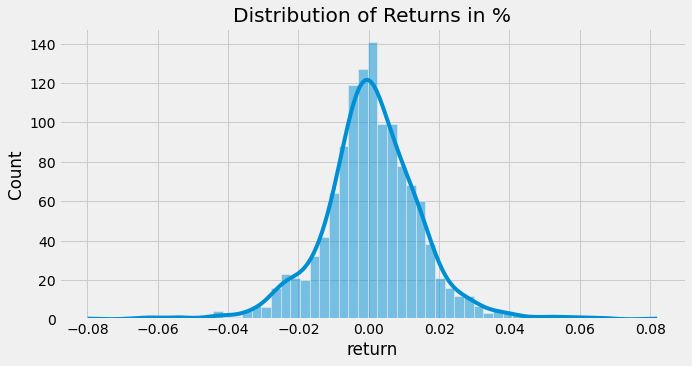

In [ ]:
apple['return']=apple['close'].pct_change()
plt.figure(figsize=(10, 5))
sns.histplot(apple['return'], kde=True)
plt.title('Distribution of Returns in %')
plt.show()

In [ ]:
apple['sma'] = apple['close'].rolling(window=30).mean()
apple['sms'] = apple['close'].rolling(window=30).std()

apple['upper'] = apple['sma'] + (apple['sms']*2)
apple['lower'] = apple['sma'] - (apple['sms']*2)

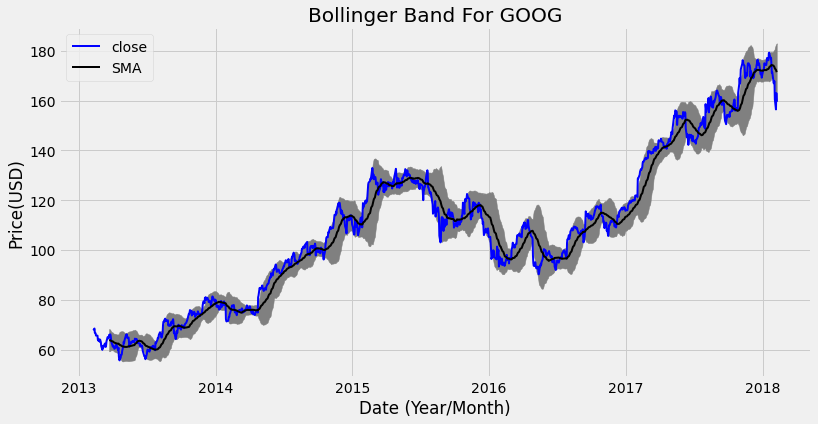

In [ ]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

x_axis = apple.index
ax.fill_between(x_axis, apple['upper'], apple['lower'], color='grey')
ax.plot(x_axis, apple['close'], color='blue', lw=2, label='close')
ax.plot(x_axis, apple['sma'], color='black', lw=2, label='SMA')

ax.set_title('Bollinger Band For GOOG')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()